In [1]:
#hide
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
import numpy as np 

# Read input data: digit images

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/home/mchristos/.fastai/data/mnist_sample/labels.csv'),Path('/home/mchristos/.fastai/data/mnist_sample/valid'),Path('/home/mchristos/.fastai/data/mnist_sample/train')]

We have a training and validation set of mnist digits 3 and 7 

In [5]:
threePaths = (path/'train'/'3').ls()
sevenPaths = (path/'train'/'7').ls()

Run below to see a random three or seven image

In [6]:
randomIndex = np.random.randint(len(threePaths))
im3=Image.open(threePaths[randomIndex])
im3

In [7]:
randomIndex = np.random.randint(len(sevenPaths))
im7=Image.open(sevenPaths[randomIndex])
im7

In [8]:
tensor(im3)[4:30,4:20]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  39, 133, 180,  93,  71,  71,  11,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  32, 206, 229, 120, 235, 254, 243,  56,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 104, 237, 253, 176,  13,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  53, 253, 253,  84,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7, 202, 198,  24,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 106, 253,  96,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  41, 232, 253,  96,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 167, 255, 253,  96,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 151, 252, 255, 231,   9,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 121, 248, 254, 252, 149,   0,   0,   0],
        [ 

# First Model

In [9]:
threes = [tensor(Image.open(x)) for x in threePaths ]
sevens = [tensor(Image.open(x)) for x in sevenPaths ]

In [10]:
print(len(threes), len(sevens))

6131 6265


<AxesSubplot:>

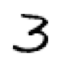

In [11]:
show_image(threes[0])

In [12]:
stacked_threes = torch.stack(threes).float()
stacked_sevens = torch.stack(sevens).float()

In [45]:
# confirm that pixel values are in the range 0-255 (i.e. 256 range)
print(stacked_threes.min(), stacked_threes.max())
print(stacked_threes.min(), stacked_sevens.max())

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


Image pixel values are between 0 and 255 so we can scale it to be between - and 1 

In [14]:
stacked_threes = torch.stack(threes).float()/255
stacked_sevens = torch.stack(sevens).float()/255

In [15]:
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
len(stacked_threes)

6131

We now have all our images stacked up in a single tensor (can imagine a cube stacked up with 2D images). Each image is 28 x 28, and for threes we have 6131 images. Interestingly the len() of these pytorch tensors are the rank (or dimension), i.e. 3

<AxesSubplot:>

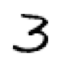

In [17]:
show_image(stacked_threes[0])

## compute the "average" 3

We simply compute the mean over all images, i.e. mean along the 0 axis (the one of length number of images)

<AxesSubplot:>

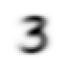

In [18]:
mean_three = stacked_threes.mean(0)
show_image(mean_three)

<AxesSubplot:>

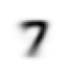

In [19]:
mean_svn = stacked_sevens.mean(0)
show_image(mean_svn)

In [20]:
type(mean_three)

torch.Tensor

In [21]:
def classify(image: torch.Tensor):
    """
    Classify as 28 x 28 image represented as a pytorch tensor
    
    Returns the digit which has the least mean squared distance from the image. i.e. we decide if itsa seven or a three 
    by seeing which "ideal" digit its closest to
    """
    distance_three = ((image - mean_three)**2).sum().sqrt()
    # or, compute this with the pytorch loss function MSE (mean squared error) 
    distance_three = F.mse_loss(image, mean_three).sqrt()
    distance_svn = F.mse_loss(image, mean_svn).sqrt()
    return 0 if distance_svn < distance_three else 1

## Evaluate our classifier on the test set 

In [22]:
testThrees = [tensor(Image.open(p)) for p in (path/'valid'/'3').ls()]
testSvns = [tensor(Image.open(p)) for p in (path/'valid'/'7').ls()]

In [23]:
X = testThrees + testSvns
y = tensor(len(testThrees)*[1] + len(testSvns)*[0]) 

In [24]:
y_pred = tensor([classify(x) for x in X])

In [25]:
y_pred

tensor([1, 1, 1,  ..., 1, 0, 0])

In [26]:
accuracy = 1- ((y - y_pred)**2).sum()/len(y)
accuracy

tensor(0.9475)

In [27]:
# Precision on predicting 3 
# i.e. out of all the times we predicted 3, what fraction was correct? 
precision_3 = torch.logical_and(y_pred == 1,y == y_pred).sum() / (y_pred==1).sum()
precision_3

tensor(0.9161)

In [28]:
# Recall on digit 3 
# i.e. out of all the true 3 digits, what fraction did we "hit"? 
recall_3 = torch.logical_and(y == 1,y == y_pred).sum() / (y==1).sum()
recall_3

tensor(0.9842)

Our recall is more than 98%, so almost all of the actual 3's we predict correctly. OUr precision on 3 is a bit lower, so that means that we're predicting 3 on some digits that were actually a 7. As you can see below, we are predicting 1085 digits to be a 3 but there are only 1010 true 3s.

In [29]:
print((y_pred==1).sum())
print((y==1).sum())

tensor(1085)
tensor(1010)


Overall pretty damn impressive for such a naive algorithm! 

## Vectorize that code 

I wrote that off the top of my head, and one bad thing I did is use a python loop (list comprehension) to compute all the predictions in batch on the validation set. Lets rather do this in a vectorized manner 

In [72]:
# l2 distanec 
def mnist_distance(im_a, im_b): return ((im_a - im_b)**2).sum().sqrt()
# l1 distance 
def mnist_distance(im_a,im_b): return (im_a-im_b).abs().mean((-1,-2))

In [73]:
valid_3s = torch.stack([tensor(Image.open(p)) for p in (path/'valid'/'3').ls()]).float()/255
valid_7s = torch.stack([tensor(Image.open(p)) for p in (path/'valid'/'7').ls()]).float()/255

In [74]:
def is_3(image): return mnist_distance(image, mean_three) < mnist_distance(image, mean_svn)

In [75]:
X_val = torch.stack([*valid_3s, *valid_7s])
y_val = tensor(len(valid_3s)*[1] + len(valid_7s)*[0]).float()

In [76]:
y_pred = is_3(X_val).float()

In [77]:
accuracy = (y_pred == y_val).sum() / len(y_val)
accuracy

tensor(0.9514)

In [70]:
precision_3 = torch.logical_and(y_pred == 1,y_val == y_pred).sum() / (y_pred==1).sum()
precision_3

tensor(0.9841)

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[1013,   15],
       [  84,  926]])

## Training a REAL model 

lets prepare our training data - we'll flatten each image into a single vector (28x28=784) and use 784 weights, one for each pixel. 

In [78]:
threes = [tensor(Image.open(x)) for x in (path/'train'/'3').ls() ]
sevens = [tensor(Image.open(x)) for x in (path/'train'/'7').ls() ]
stacked_3s = torch.stack(threes).float()/255
stacked_7s = torch.stack(sevens).float()/255

In [79]:
print(stacked_3s.shape)
print(stacked_7s.shape)

torch.Size([6131, 28, 28])
torch.Size([6265, 28, 28])


In [80]:
# cast each 2d image into a 1d array 
train_x = torch.cat([stacked_3s, stacked_7s]).view(-1,28*28)
train_x.shape

torch.Size([12396, 784])

In [81]:
# in python list1 + list2 concatenates the contents of the two lists
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [82]:
# define a dataset of (image, label) tuples 
dset_train = list(zip(train_x, train_y))
x,y = dset_train[0]
x.shape, y 

(torch.Size([784]), tensor([1]))

In [291]:
valid_3s = [tensor(Image.open(x)) for x in (path/'valid'/'3').ls()]
valid_7s = [tensor(Image.open(x)) for x in (path/'valid'/'7').ls()]
valid_x = torch.cat ([
    torch.stack(valid_3s).float()/255,
    torch.stack(valid_7s).float()/255
]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3s) + [0]*len(valid_7s)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [292]:
dset_valid = list(zip(valid_x, valid_y))

In [293]:
# initialize parameters randomly from a normal distribution around 0 with std=1
# remember to mark the parameters as requiring grad, since we will be updating them based on gradients! 
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

Initialize a model by defining a set of 784 weights (that's 28*28, i.e. a weight for every pixel) plus a bias. We compute the prediction by taking the dot product of an image with the weights vector, and adding the bias (a number). 

Since weights are pulled from a normal distribution around zero, they are equally likely to push the final prediction to be a positive or a negative number. So we can arbitrarily decide that a positive number means a 3, and a negative number means 7 

In [294]:
# Randomly initialize weights and bias 
# y = w*x + b
weights = init_params([28*28,1])
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [295]:
# compute a prediction 
# (+) => 3 , (-) => 7
(train_x[0]*weights.T).sum() + bias

tensor([-6.8456], grad_fn=<AddBackward0>)

In [296]:
# or do the same with matrix multiplication 
train_x[0]@weights + bias

tensor([-6.8456], grad_fn=<AddBackward0>)

In [297]:
# to compute predictions on the whole batch at once, we can use matrix multiplication
def linear1(X): return X@weights + bias

preds = linear1(train_x)
predicted_y = (preds > 0).float()
predicted_y, train_y  

(tensor([[0.],
         [0.],
         [1.],
         ...,
         [1.],
         [0.],
         [1.]]),
 tensor([[1],
         [1],
         [1],
         ...,
         [0],
         [0],
         [0]]))

In [298]:
corrects = predicted_y == train_y
accuracy = corrects.float().sum()/len(corrects)
accuracy

tensor(0.4184)

Looks like our accuracy is close to 0.5, i.e. pretty much random, and that's exactly what we would expect for randomly initialized weights

Now we need to decide on a loss function and start tuning those weights! First we'll use the sigmoid function to make sure all predictions are between 0 and 1 rather than from [-inf,+inf]. Then we can easily get a distance between a predition (say it's 0.6) and the correct answer, either 0 (3) or 1 (7) 

In [299]:
def sigmoid(x): return 1 / (1 + torch.exp(-x))

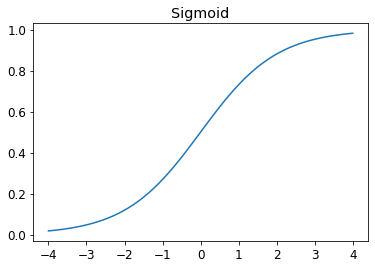

In [300]:
plot_function(sigmoid, title="Sigmoid", min=-4,max=4)

In [301]:
preds.sigmoid()

tensor([[1.0630e-03],
        [8.5616e-04],
        [9.6794e-01],
        ...,
        [9.1929e-01],
        [1.4317e-03],
        [6.7517e-01]], grad_fn=<SigmoidBackward0>)

In [302]:
def mnist_loss(predictions, targets):
    "Computes the loss for a whole batch of predictions. We take the mean of the loss for each prediction"
    sigpreds = predictions.sigmoid()
    return (targets - sigpreds).abs().mean() 

In [303]:
mnist_loss(preds, train_y)

tensor(0.5776, grad_fn=<MeanBackward0>)

## DataLoader and mini-batches 

In [304]:
# create 15 data points 
data = range(15)
dl = DataLoader(data, batch_size=5, shuffle=True)
list(dl)

[tensor([0, 3, 6, 1, 5]),
 tensor([10,  8, 12,  9,  4]),
 tensor([13,  7,  2, 11, 14])]

In [305]:
# Usually you feed a dataloader a dataset of (x,y) tuples where y is the label and x the input. 
dl_train = DataLoader(dset_train, batch_size=256)
len(dl_train), len(dset_train)

(49, 12396)

In [306]:
12396 - 48*256

108

We have 49 batches of size 256 - that makes space for 49x256=12544 data points, i.e. enough space for our dataset (the last batch is smaller, with 12396 - 48x256 = 108 data points - check for yourself by getting the last batch in the data loader)

In [307]:
# This is our first batch of data: 
x_batch, y_batch = list(dl_train)[0]
x_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [308]:
# create another data loader for the validation set 
dl_valid = DataLoader(dset_valid,batch_size=256)

In [309]:
x,y=list(dl_valid)[-1]
x.shape

torch.Size([246, 784])

In [310]:
train_x.shape

torch.Size([12396, 784])

## Ok let's try training something using gradients!  

In [311]:
# manually try with a batch size of 4  
batch = train_x[:4]
batch.shape 

torch.Size([4, 784])

In [312]:
preds = linear1(batch)
preds
# remember that sigmoid values are bundled into the loss function 

tensor([[-6.8456],
        [-7.0622],
        [ 3.4075],
        [-5.1138]], grad_fn=<AddBackward0>)

In [313]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7560, grad_fn=<MeanBackward0>)

In [314]:
loss.backward()

In [315]:
weights.grad.mean(), bias.grad

(tensor(-0.0017), tensor([-0.0097]))

In [364]:
def calc_grad(xb,yb,model):
    """
    Calculate the gradient on all the parameters implicit in the model. 
    This modifies the gradient attributes on the relevant parameter objects, and these can be used 
    to update the params 
    xb: batch of inputs 
    yb: batch of labels 
    model: function that computes (batch of) predictions relative to current param values 
    """
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    # modified the gradient attributes of the weights, which are implicit in the "model" definition
    # , in our case linear1
    loss.backward()

In [317]:
# we need to zero the gradients before recomputing, otherwise it adds to the gradients
# that are currently stored for the weights
#  
# note: methods ending in _ in pytorch mean they modify the object ("in-place" operation)
weights.grad.zero_()
bias.grad.zero_()
calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0017), tensor([-0.0097]))

In [327]:
def train_epoch(model, lr, params):
    """
    model: 
        function that computes the batch of outputs from a batch of inputs. Model weights 
        are implicit in this function
    lr: 
        learning rate 
    params: 
        Each of the (sets of) parameters that update based on gradient. 
        In our case, they are "weights" and "bias"  
    """
    for xb, yb in dl_train:
        calc_grad(xb,yb,model)
        for p in params:
            # update all the weights / bias
            p.data -= p.grad*lr
            p.grad.zero_()


In [328]:
def batch_accuracy(y_preds,y_batch):
    preds = y_preds.sigmoid()
    correct = (preds > 0.5) == y_batch
    # mean of array of 0/1 values is the same as the fraction of values that are 1
    return correct.float().mean()

In [329]:
batch_accuracy(linear1(train_x[:4]), train_y[:4])

tensor(0.2500)

In [359]:
# define a function that tells how well our current model is doing on our validation set 
def validate_model(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dl_valid]
    return torch.stack(accs).mean().item()
validate_model(linear1)

0.4660862684249878

In [360]:
# right now we're doing pretty bad! let's see if training for one epoch helps
train_epoch(linear1, lr=1., params=[weights, bias])
validate_model(linear1)

0.656150758266449

It definitely got better! let's try training for a few more epochs in a loop 

In [363]:
# let's train now for a few more epochs! I'll re-initialize weights just to see the uptrend
weights = init_params([28*28,1])
bias = init_params(1)
for i in range(20):
    train_epoch(linear1, lr=1., params=[weights, bias])
    acc = validate_model(linear1)
    print(acc)

0.6517959237098694
0.8329482674598694
0.8973815441131592
0.931541383266449
0.9437285661697388
0.9505645036697388
0.9554473161697388
0.9598418474197388
0.9632995128631592
0.9642760753631592
0.9652526378631592
0.9657409191131592
0.9672057628631592
0.9676940441131592
0.9686706066131592
0.9696471691131592
0.9701354503631592
0.9706237316131592
0.9706237316131592
0.9711120128631592


tensor(1747)

(<AxesSubplot:>, tensor([0]))

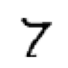

In [400]:
# I want to see it just to be sure 
rand_index = torch.randint(0,len(dset_valid),[1])[0]
sample_x, sample_y = dset_valid[rand_index]
show_image(sample_x.reshape([28,28])), sample_y

In [401]:
# 1 => 3, 0 => 7
round(float(linear1(sample_x).sigmoid()[0])), sample_y

(0, tensor([0]))

Sure seems to get the correct answer on random validation samples! We get 97% accuracy after 20 epochs 

## Doing training the fastai way 
### (using an Optimizer)

First off, we use pytorch's built-in linear function instead of manually defining it. This comes with a set of weights and bias built in. 

In [432]:
linear_model = nn.Linear(28*28,1)

In [433]:
w,b=linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [434]:
# definte our own Optimizer class 

class BasicOptimizer:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [435]:
# define optimizer class
opt = BasicOptimizer(linear_model.parameters(), lr=1.)
# training loop can now be written like this: 
def train_epoch(model, optimizer):
    for xb, yb in dl_train:
        calc_grad(xb,yb,model)
        optimizer.step()
        optimizer.zero_grad()

In [436]:
def train_model(model, optimizer, n_epochs):
    for i in range(n_epochs):
        train_epoch(model, optimizer)
        print(validate_model(model), end=" ")

In [448]:
linear_model = nn.Linear(28*28,1)
opt = BasicOptimizer(linear_model.parameters(), lr=1.)
train_model(linear_model, opt, 10)


0.4931640625 0.7128707766532898 0.8515426516532898 0.9130660891532898 0.9360153079032898 0.9516403079032898 0.9599410891532898 0.9648239016532898 0.9677535891532898 0.9687301516532898 

We wrote the optimizer class ourselves in this intance but, you guessed it, fastai provides built-in optimizers like this. For example, _stochastic_ gradient descent 

In [449]:
linear_model = nn.Linear(28*28,1)
optimizer = SGD(linear_model.parameters(), lr=1.)
train_model(linear_model, optimizer, 10)

0.4931640625 0.8198043704032898 0.8329879641532898 0.9072067141532898 0.9340621829032898 0.9496871829032898 0.9579879641532898 0.9653121829032898 0.9672653079032898 0.9687301516532898 